In [125]:
import zipfile
import requests

# Downloading the dataset
url = "https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip"
response = requests.get(url)

# Save the downloaded zip file
with open("jena_climate_2009_2016.csv.zip", "wb") as f:
    f.write(response.content)

# Unzip the downloaded file
with zipfile.ZipFile("jena_climate_2009_2016.csv.zip", "r") as zip_ref:
    zip_ref.extractall(".")

Examining the Jena meteorological dataset's 420451 rows and 15 features

In [126]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

num_variables = len(header)
print("Number of variables:", num_variables)
num_rows = len(lines)
print("Number of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


The process of parsing the data involves transforming the values separated by commas into floating-point numbers. Specific values are then stored for later processing or analysis in the raw_data and temperature arrays.

In [127]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

The temperature time series is plotted.

Text(0, 0.5, 'Temperature')

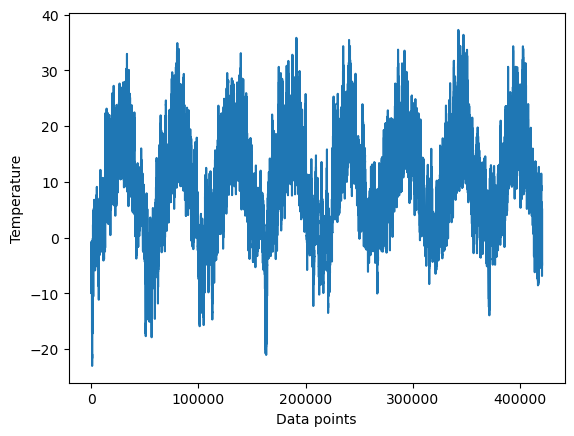

In [128]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.xlabel('Data points')
plt.ylabel('Temperature')

Plotting the temperature timeseries' first ten days: Given that there are 144 data points in a day, there will be 1440 data points in ten days.]
]


Text(0, 0.5, 'Temperature')

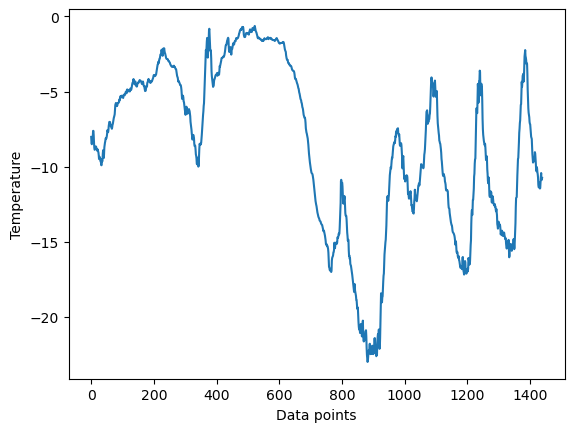

In [129]:
plt.plot(range(1440), temperature[:1440])
plt.xlabel('Data points')
plt.ylabel('Temperature')

Estimating the quantity of samples we'll need for each data split (train = 50%, validation = 25%).



In [130]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


Preparing the data

Normalizing the data: Vectorization is not required because the data is already in a numerical representation. Nonetheless, it is advised to normalize all variables because the data scales vary amongst them, with temperature ranging from -20 to +30 and pressure measured in millibars.

In [131]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [132]:
import numpy as np
from tensorflow import keras

int_sequence = np.arange(14)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-5],
    targets=int_sequence[5:],
    sequence_length=5,
    batch_size=4,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2, 3, 4] 5
[1, 2, 3, 4, 5] 6
[2, 3, 4, 5, 6] 7
[3, 4, 5, 6, 7] 8
[4, 5, 6, 7, 8] 9


Creating datasets for testing, validation, and training is necessary because the dataset's samples are largely duplicated. Thus, explicitly allocating memory for every sample would be inefficient. Rather, we shall produce the samples in real time.

In [133]:
sampling_rate = 8
sequence_length = 140
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 289

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

Examining the results of one of our databases

In [134]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (289, 140, 14)
targets shape: (289,)


A common-sense, non-machine-learning baseline

Calculating the sensible baseline MAE - The "evaluate_naive_method" defined function offers a starting point for assessing the effectiveness of a straightforward forecasting technique that uses the final value in the input sequence to predict the value that will come after it.

In [135]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 4.32
Test MAE: 4.65


A sensible baseline method would be to forecast that the temperature in the next 24 hours will be the same as it is now. The validation MAE (Mean Absolute Error) using the simple baseline is 2.44 degrees Celsius, while the test MAE is 2.62 degrees Celsius. Put another way, an average divergence of roughly 2.5 degrees would arise from presuming that the future temperature stays constant with the current temperature.

A basic machine-learning model - Dense Layer



Constructing and assessing a densely linked model

from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [139]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [140]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

In [141]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [142]:
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, callbacks=callbacks)

Epoch 1/10
724/724 [==============================] - 8s 10ms/step - loss: 15.7520 - mae: 3.0773 - val_loss: 14.1304 - val_mae: 2.9658
Epoch 2/10
724/724 [==============================] - 7s 10ms/step - loss: 10.7416 - mae: 2.5832 - val_loss: 16.3045 - val_mae: 3.2222
Epoch 3/10
724/724 [==============================] - 7s 10ms/step - loss: 9.6539 - mae: 2.4517 - val_loss: 15.6362 - val_mae: 3.1427
Epoch 4/10
724/724 [==============================] - 10s 14ms/step - loss: 8.9465 - mae: 2.3657 - val_loss: 14.5640 - val_mae: 3.0268
Epoch 5/10
724/724 [==============================] - 10s 13ms/step - loss: 8.4970 - mae: 2.3083 - val_loss: 15.7974 - val_mae: 3.1675
Epoch 6/10
724/724 [==============================] - 10s 14ms/step - loss: 8.0750 - mae: 2.2528 - val_loss: 14.4339 - val_mae: 3.0133
Epoch 7/10
724/724 [==============================] - 10s 14ms/step - loss: 7.7302 - mae: 2.2021 - val_loss: 15.0688 - val_mae: 3.0790
Epoch 8/10
724/724 [==============================] - 9s

In [143]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

356/356 [==============================] - 3s 7ms/step - loss: 16.0853 - mae: 3.1673
Test MAE: 3.17


Plotting results

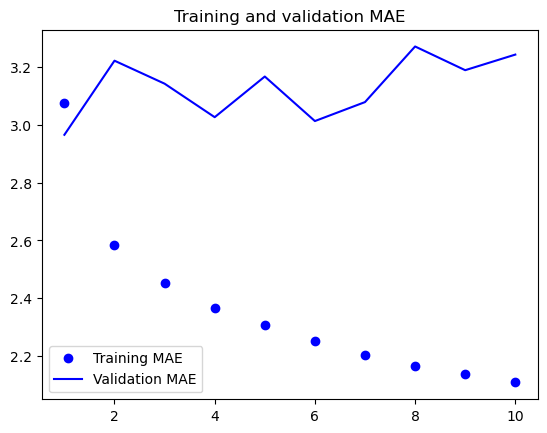

In [144]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Let's try a 1D convolutional model

In [145]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(6, 26, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(6, 13, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(6, 7, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
724/724 [==============================] - 21s 28ms/step - loss: 24.6299 - mae: 3.8764 - val_loss: 20.5010 - val_mae: 3.6109
Epoch 2/10
724/724 [==============================] - 24s 33ms/step - loss: 16.6843 - mae: 3.2498 - val_loss: 21.6448 - val_mae: 3.7357
Epoch 3/10
724/724 [==============================] - 23s 31ms/step - loss: 15.1951 - mae: 3.1010 - val_loss: 19.0392 - val_mae: 3.4625
Epoch 4/10
724/724 [==============================] - 25s 35ms/step - loss: 14.2918 - mae: 3.0098 - val_loss: 19.2194 - val_mae: 3.4676
Epoch 5/10
724/724 [==============================] - 22s 31ms/step - loss: 13.6476 - mae: 2.9372 - val_loss: 20.7116 - val_mae: 3.5978
Epoch 6/10
724/724 [==============================] - 23s 31ms/step - loss: 13.1149 - mae: 2.8767 - val_loss: 19.4550 - val_mae: 3.5004
Epoch 7/10
724/724 [==============================] - 24s 33ms/step - loss: 12.6086 - mae: 2.8176 - val_loss: 19.3656 - val_mae: 3.4891
Epoch 8/10
724/724 [============================

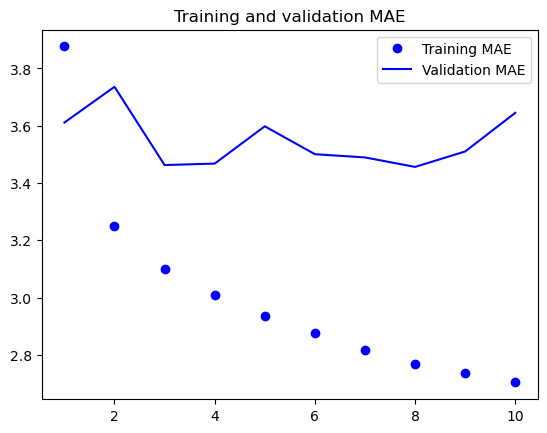

In [146]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs,  val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

It appears that the convolutional data did not perform as well as the dense model or common sense. This might be the case because
- 
For meteorological data, the translation invariance assumption is not very strong.- 

The data's order is very important. When it comes to forecasting the temperature for the next day, recent historical data is noticeably more useful than data collected several days prior. Sadly, this crucial temporal order is beyond the reach of a 1D convolutional neural network.

A Simple RNN

1. An RNN layer that can process sequences of any length

In [147]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
724/724 [==============================] - 24s 32ms/step - loss: 139.2446 - mae: 9.7150 - val_loss: 144.6932 - val_mae: 9.9395
Epoch 2/10
724/724 [==============================] - 28s 39ms/step - loss: 136.6258 - mae: 9.5818 - val_loss: 144.5615 - val_mae: 9.9316
Epoch 3/10
724/724 [==============================] - 26s 35ms/step - loss: 136.5630 - mae: 9.5773 - val_loss: 144.4559 - val_mae: 9.9208
Epoch 4/10
724/724 [==============================] - 25s 35ms/step - loss: 136.4158 - mae: 9.5669 - val_loss: 144.3124 - val_mae: 9.9109
Epoch 5/10
724/724 [==============================] - 25s 34ms/step - loss: 136.3459 - mae: 9.5621 - val_loss: 144.2202 - val_mae: 9.8992
Epoch 6/10
724/724 [==============================] - 25s 34ms/step - loss: 136.3415 - mae: 9.5619 - val_loss: 144.1506 - val_mae: 9.8909
Epoch 7/10
724/724 [==============================] - 26s 35ms/step - loss: 136.2910 - mae: 9.5574 - val_loss: 144.1319 - val_mae: 9.8884
Epoch 8/10
724/724 [==============

A Simple GRU (Gated Recurrent Unit)

In [172]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
724/724 [==============================] - 96s 113ms/step - loss: 47.5070 - mae: 5.1913 - val_loss: 20.1845 - val_mae: 3.4774
Epoch 2/10
724/724 [==============================] - 85s 117ms/step - loss: 16.1268 - mae: 3.1515 - val_loss: 15.2879 - val_mae: 3.0678
Epoch 3/10
724/724 [==============================] - 85s 117ms/step - loss: 13.2874 - mae: 2.8591 - val_loss: 14.7941 - val_mae: 3.0351
Epoch 4/10
724/724 [==============================] - 88s 122ms/step - loss: 12.4176 - mae: 2.7561 - val_loss: 15.0397 - val_mae: 3.0476
Epoch 5/10
724/724 [==============================] - 87s 120ms/step - loss: 11.7393 - mae: 2.6766 - val_loss: 14.6102 - val_mae: 3.0055
Epoch 6/10
724/724 [==============================] - 90s 124ms/step - loss: 11.2390 - mae: 2.6186 - val_loss: 15.7599 - val_mae: 3.0754
Epoch 7/10
724/724 [==============================] - 87s 120ms/step - loss: 10.8321 - mae: 2.5690 - val_loss: 14.9313 - val_mae: 3.0210
Epoch 8/10
724/724 [=====================

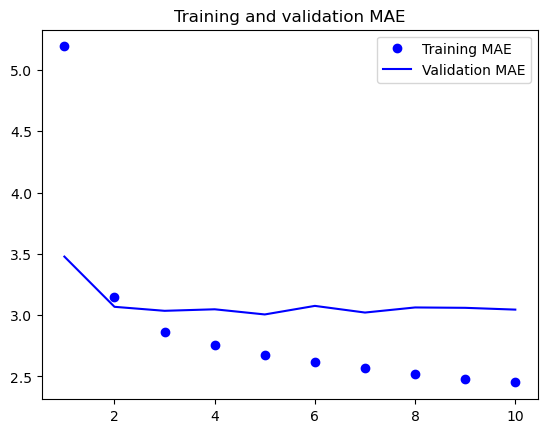

In [173]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs,  val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

LSTM(Long Short-Term Memory )

1.LSTM-Simple

In [179]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
724/724 [==============================] - 74s 100ms/step - loss: 43.4870 - mae: 4.9394 - val_loss: 19.9011 - val_mae: 3.4819
Epoch 2/10
724/724 [==============================] - 76s 105ms/step - loss: 17.0959 - mae: 3.2434 - val_loss: 17.0937 - val_mae: 3.2595
Epoch 3/10
724/724 [==============================] - 76s 105ms/step - loss: 14.1525 - mae: 2.9469 - val_loss: 15.7034 - val_mae: 3.1163
Epoch 4/10
724/724 [==============================] - 77s 106ms/step - loss: 12.5598 - mae: 2.7701 - val_loss: 15.4862 - val_mae: 3.0861
Epoch 5/10
724/724 [==============================] - 76s 105ms/step - loss: 11.6523 - mae: 2.6655 - val_loss: 14.7354 - val_mae: 2.9951
Epoch 6/10
724/724 [==============================] - 78s 107ms/step - loss: 11.2517 - mae: 2.6137 - val_loss: 14.6824 - val_mae: 3.0097
Epoch 7/10
724/724 [==============================] - 77s 106ms/step - loss: 10.7711 - mae: 2.5559 - val_loss: 14.5589 - val_mae: 2.9773
Epoch 8/10
724/724 [=====================

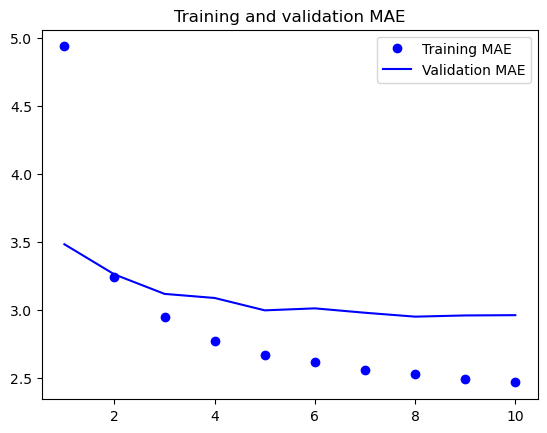

In [180]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs,  val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

2.LSTM - Dropout Regularization

In [176]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
724/724 [==============================] - 102s 138ms/step - loss: 53.1571 - mae: 5.5466 - val_loss: 20.7640 - val_mae: 3.5101
Epoch 2/10
724/724 [==============================] - 102s 141ms/step - loss: 26.6818 - mae: 4.0112 - val_loss: 16.7045 - val_mae: 3.1914
Epoch 3/10
724/724 [==============================] - 101s 140ms/step - loss: 23.6524 - mae: 3.7705 - val_loss: 15.1477 - val_mae: 3.0385
Epoch 4/10
724/724 [==============================] - 101s 139ms/step - loss: 21.9664 - mae: 3.6341 - val_loss: 13.8900 - val_mae: 2.9119
Epoch 5/10
724/724 [==============================] - 102s 140ms/step - loss: 20.8093 - mae: 3.5359 - val_loss: 13.2314 - val_mae: 2.8404
Epoch 6/10
724/724 [==============================] - 103s 142ms/step - loss: 19.8920 - mae: 3.4555 - val_loss: 13.3263 - val_mae: 2.8681
Epoch 7/10
724/724 [==============================] - 104s 143ms/step - loss: 19.3562 - mae: 3.4099 - val_loss: 12.4919 - val_mae: 2.7815
Epoch 8/10
724/724 [==============

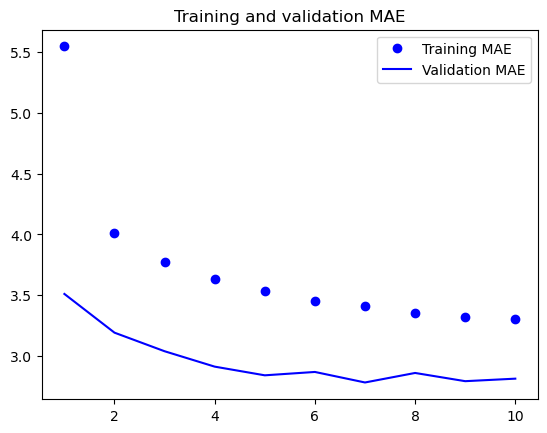

In [178]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs,  val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

3.LSTM - Stacked setup with 16 units

In [74]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
724/724 [==============================] - 188s 254ms/step - loss: 40.0145 - mae: 4.7189 - val_loss: 18.0143 - val_mae: 3.2777
Epoch 2/10
724/724 [==============================] - 190s 262ms/step - loss: 13.6275 - mae: 2.8793 - val_loss: 15.1919 - val_mae: 3.0613
Epoch 3/10
724/724 [==============================] - 186s 257ms/step - loss: 11.3519 - mae: 2.6339 - val_loss: 15.6024 - val_mae: 3.0988
Epoch 4/10
724/724 [==============================] - 188s 259ms/step - loss: 10.2872 - mae: 2.5123 - val_loss: 15.0100 - val_mae: 3.0503
Epoch 5/10
724/724 [==============================] - 194s 268ms/step - loss: 9.5684 - mae: 2.4226 - val_loss: 15.9344 - val_mae: 3.1245
Epoch 6/10
724/724 [==============================] - 188s 259ms/step - loss: 9.0004 - mae: 2.3497 - val_loss: 16.9849 - val_mae: 3.2107
Epoch 7/10
724/724 [==============================] - 186s 257ms/step - loss: 8.5902 - mae: 2.2933 - val_loss: 16.7022 - val_mae: 3.1936
Epoch 8/10
724/724 [=================

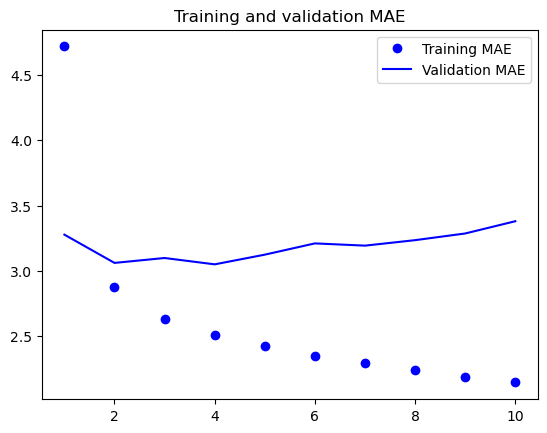

In [75]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs,  val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

4.LSTM - Stacked setup with 32 units

In [76]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
724/724 [==============================] - 216s 293ms/step - loss: 24.8210 - mae: 3.6703 - val_loss: 16.0615 - val_mae: 3.1321
Epoch 2/10
724/724 [==============================] - 223s 308ms/step - loss: 9.9205 - mae: 2.4561 - val_loss: 16.4454 - val_mae: 3.1550
Epoch 3/10
724/724 [==============================] - 227s 314ms/step - loss: 7.5262 - mae: 2.1256 - val_loss: 16.4716 - val_mae: 3.1839
Epoch 4/10
724/724 [==============================] - 229s 317ms/step - loss: 6.2931 - mae: 1.9276 - val_loss: 17.3270 - val_mae: 3.2574
Epoch 5/10
724/724 [==============================] - 229s 316ms/step - loss: 5.4448 - mae: 1.7798 - val_loss: 18.8254 - val_mae: 3.4016
Epoch 6/10
724/724 [==============================] - 232s 320ms/step - loss: 4.7078 - mae: 1.6462 - val_loss: 19.8907 - val_mae: 3.5218
Epoch 7/10
724/724 [==============================] - 232s 320ms/step - loss: 4.2078 - mae: 1.5531 - val_loss: 19.8129 - val_mae: 3.4848
Epoch 8/10
724/724 [====================

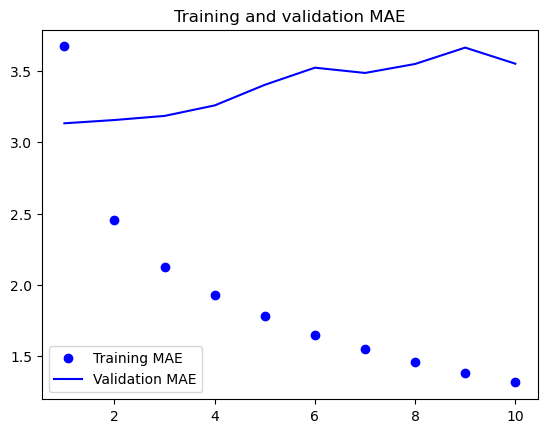

In [77]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs,  val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

4.LSTM - Stacked setup with 8 units

In [78]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
724/724 [==============================] - 66s 86ms/step - loss: 79.4656 - mae: 6.9472 - val_loss: 46.9724 - val_mae: 5.2359
Epoch 2/10
724/724 [==============================] - 63s 87ms/step - loss: 31.0018 - mae: 4.2345 - val_loss: 21.5852 - val_mae: 3.5918
Epoch 3/10
724/724 [==============================] - 65s 89ms/step - loss: 18.0414 - mae: 3.3117 - val_loss: 15.5861 - val_mae: 3.0726
Epoch 4/10
724/724 [==============================] - 64s 88ms/step - loss: 14.4340 - mae: 2.9800 - val_loss: 14.4243 - val_mae: 2.9630
Epoch 5/10
724/724 [==============================] - 64s 88ms/step - loss: 13.5084 - mae: 2.8883 - val_loss: 13.6132 - val_mae: 2.8761
Epoch 6/10
724/724 [==============================] - 66s 91ms/step - loss: 12.8676 - mae: 2.8188 - val_loss: 14.0210 - val_mae: 2.9228
Epoch 7/10
724/724 [==============================] - 66s 91ms/step - loss: 12.3700 - mae: 2.7615 - val_loss: 13.4655 - val_mae: 2.8734
Epoch 8/10
724/724 [============================

5.LSTM - dropout-regularized, stacked model

In [79]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
724/724 [==============================] - 156s 208ms/step - loss: 76.2074 - mae: 6.7589 - val_loss: 40.3100 - val_mae: 4.8627
Epoch 2/10
724/724 [==============================] - 154s 213ms/step - loss: 37.6151 - mae: 4.6690 - val_loss: 20.4959 - val_mae: 3.4672
Epoch 3/10
724/724 [==============================] - 155s 214ms/step - loss: 30.3465 - mae: 4.2187 - val_loss: 17.6005 - val_mae: 3.2583
Epoch 4/10
724/724 [==============================] - 154s 212ms/step - loss: 27.4991 - mae: 4.0217 - val_loss: 16.5331 - val_mae: 3.1648
Epoch 5/10
724/724 [==============================] - 176s 243ms/step - loss: 25.8638 - mae: 3.9009 - val_loss: 15.6397 - val_mae: 3.0906
Epoch 6/10
724/724 [==============================] - 154s 213ms/step - loss: 24.5305 - mae: 3.8037 - val_loss: 15.4130 - val_mae: 3.0681
Epoch 7/10
724/724 [==============================] - 170s 235ms/step - loss: 23.2157 - mae: 3.7021 - val_loss: 14.8838 - val_mae: 3.0188
Epoch 8/10
724/724 [==============

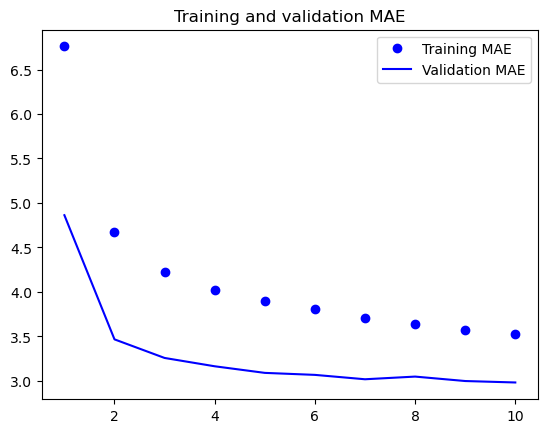

In [80]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs,  val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Bidirectional LSTM

In [81]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
724/724 [==============================] - 117s 157ms/step - loss: 29.8360 - mae: 4.0517 - val_loss: 16.0069 - val_mae: 3.1208
Epoch 2/10
724/724 [==============================] - 118s 162ms/step - loss: 13.3819 - mae: 2.8754 - val_loss: 15.6848 - val_mae: 3.1009
Epoch 3/10
724/724 [==============================] - 119s 164ms/step - loss: 11.8102 - mae: 2.6967 - val_loss: 15.7545 - val_mae: 3.1002
Epoch 4/10
724/724 [==============================] - 123s 169ms/step - loss: 10.8742 - mae: 2.5820 - val_loss: 15.0521 - val_mae: 3.0253
Epoch 5/10
724/724 [==============================] - 121s 167ms/step - loss: 10.2224 - mae: 2.5025 - val_loss: 15.1875 - val_mae: 3.0409
Epoch 6/10
724/724 [==============================] - 122s 168ms/step - loss: 9.7627 - mae: 2.4401 - val_loss: 15.5976 - val_mae: 3.0802
Epoch 7/10
724/724 [==============================] - 122s 168ms/step - loss: 9.3786 - mae: 2.3904 - val_loss: 15.4944 - val_mae: 3.0788
Epoch 8/10
724/724 [================

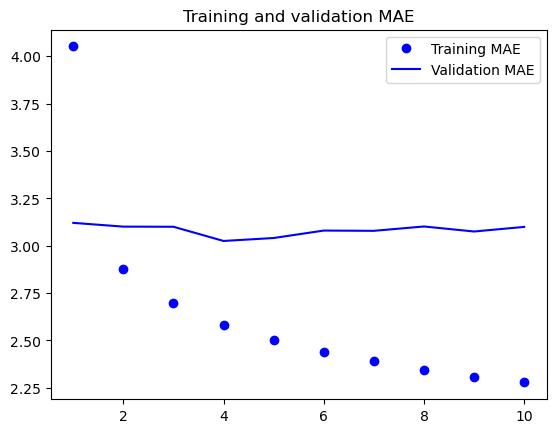

In [82]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs,  val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

1D Convnets and LSTM togther

In [83]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
724/724 [==============================] - 28s 35ms/step - loss: 56.6874 - mae: 5.6924 - val_loss: 33.4695 - val_mae: 4.5205
Epoch 2/10
724/724 [==============================] - 31s 43ms/step - loss: 19.6979 - mae: 3.3966 - val_loss: 25.4923 - val_mae: 3.9929
Epoch 3/10
724/724 [==============================] - 31s 43ms/step - loss: 15.5355 - mae: 3.0582 - val_loss: 25.8424 - val_mae: 4.0923
Epoch 4/10
724/724 [==============================] - 31s 42ms/step - loss: 13.8167 - mae: 2.8811 - val_loss: 25.5456 - val_mae: 3.9940
Epoch 5/10
724/724 [==============================] - 31s 43ms/step - loss: 12.6030 - mae: 2.7427 - val_loss: 26.6875 - val_mae: 4.1134
Epoch 6/10
724/724 [==============================] - 31s 43ms/step - loss: 11.7299 - mae: 2.6417 - val_loss: 29.8096 - val_mae: 4.3997
Epoch 7/10
724/724 [==============================] - 31s 42ms/step - loss: 11.0702 - mae: 2.5665 - val_loss: 27.7792 - val_mae: 4.1813
Epoch 8/10
724/724 [============================

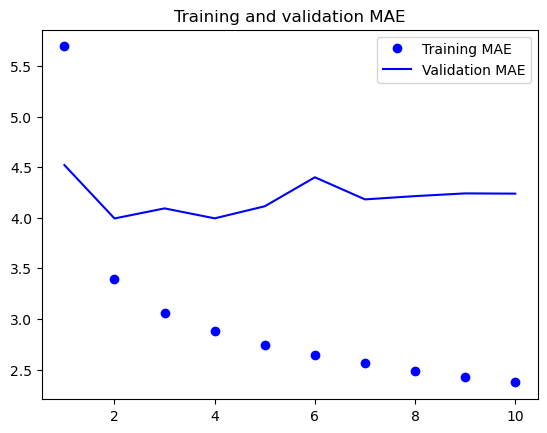

In [84]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs,  val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

We built 14 models: Following are the details;

Model 1: common-sense, non-machine-learning baseline

Model 2: A basic machine-learning model

Model 3: 1D convolutional model

Model 4: Simple RNN layer that can process sequences of an

Model 5: Simple RNN layer- Stacking RNN layersyNN laye6s

Model 6: A Simple GRU (Gated Recurrent U7it)

Model 7: LSTM-8imple

Model 8: LSTM - dropout Regula9ization

Model 9: Stacked setup wit1016 units

Model 10: Stacked setup wi1h 32 units

Model 11: Stac

Model 12: LSTM - dropout-regularized, stacked

Model313: Bidirectional LSTM

Mod4l 14: 1D Convnets and LSTM toger

ked setup with 8 units

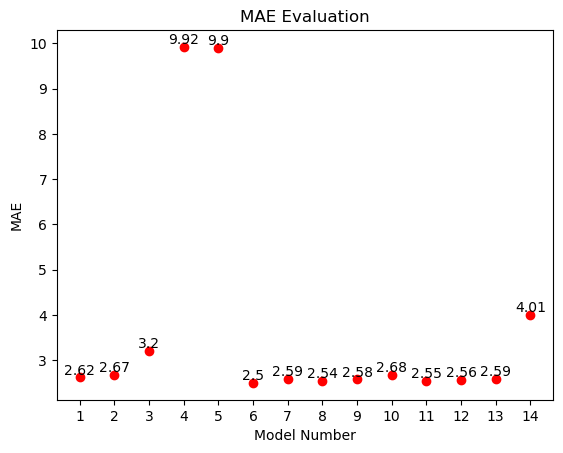

In [182]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (2.62,2.67,3.2,9.92,9.9,2.5,2.59,2.54,2.58,2.68,2.55,2.56,2.59,4.01)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()